# Brief introduction to use VitalDB_signal extractor (https://vitaldb.net/)
-------
> 1.Input your file name (.vital) <br>
> 2.Select specific time <br>
> 3.Get specific signals <br>
> Known issue : several errors in sampling rate from .vital <br>

<img src="resource/VitalDB_s.png"/>


In [1]:
# import libaries
import torch
import os
import csv
import glob
import datetime 
import numpy as np
import pandas as pd
import AMCVitalReader as vr
import matplotlib.pyplot as plt

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from os import listdir
from os.path import isfile, join
import glob

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def get_time_from_wave():
    a,b = vr_data.read_wave_datetime('DI-1120','VOLT')
    print("###File information###")
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_time_from_number():
    a,b = vr_data.read_number_datetime('Primus','CO2')
    print("[time start]",a[0])
    print("[time end]",a[-1])
    print("[time length]",a[-1]-a[0])
    print(len(a))
    return len(a)

def get_state_time(i):
    state_time=str(df_dict['Time'][i])
    start_year   = int(state_time[0:4])
    start_month  = int(state_time[5:7])
    start_date   = int(state_time[8:10])
    start_hour   = int(state_time[11:13])
    start_minute = int(state_time[14:16])
    start_second = int(state_time[17:19])

    state_time=str(df_dict['Time'][i+1])
    end_year   = int(state_time[0:4])
    end_month  = int(state_time[5:7])
    end_date   = int(state_time[8:10])
    end_hour   = int(state_time[11:13])
    end_minute = int(state_time[14:16])
    end_second = int(state_time[17:19])
    state = df_dict["State"][i]
    return start_year,start_month,start_date,start_hour,start_minute,start_second,end_year,end_month,end_date,end_hour,end_minute,end_second, state

def extract_original_wav():

    # CO2 : 1 frame 0.016s, 62.5Hz
    # AWP : 1 frame 0.016s, 62.5Hz
    # VOLT : 1 frame 0.004s, 2500Hz
    
    trigger = np.arange(0,dtype=np.float)
    for i in range(0,total_df[column_name[3]].count()):

        if total_df[column_name[3]][i] <= total_df[column_name[3]].mean():
            trigger = np.insert(trigger,i,0)
        else :
            trigger = np.insert(trigger,i,20)

    plt.figure(figsize=(8,4))
    for i in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
        plt.plot(total_df[column_name[2*i]],total_df[column_name[2*i+1]],alpha=0.5,label=column_name[2*i+1])
    plt.legend(loc='upper left')
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(total_df[column_name[3]],alpha=0.3,label=column_name[1],color='blue')
    plt.plot(trigger,alpha=0.3,label='trigger',color='red')
    plt.legend(loc='upper left')
    
#     breathing_start = np.arange(0,dtype=np.int)
#     breathing_end = np.arange(0,dtype=np.int)
                
#     plt.vlines(breathing_start/40,0,30,colors='black') # trigger start 
#     plt.vlines(breathing_end/40,0,30,colors='green')   # trigger end 
# #     plt.vlines((breathing_start-2500)/40,0,40,color='purple')
# #     plt.vlines((breathing_end+2500)/40,0,40,color='orange')
    plt.show()
    
#     print('Breathing_start',len(breathing_start),'Breathing_end',len(breathing_end))
    
#     if(len(breathing_start))>0:

        margin = 3000 # 3750

        plt.figure(figsize=(22, 6))
        for i in range(0,len(breathing_start)):
            if breathing_start[i] < margin:
                print('There is no margin to capture!')
            else:
                wav_original = np.asarray(total_df['VOLT'][breathing_start[i]-margin:breathing_end[i]+margin]).astype(np.float32)
#                 print(breathing_start[i]-margin,breathing_end[i]+margin)
                plt.subplot(2, int(len(breathing_start)/2)+1, i+1)

                librosa.display.waveplot(wav_original,label=i,alpha=0.5)
                plt.ylim(-2, 2)
                plt.legend()

                audio_path = 'output/'+fname+'/'+fname_with_time+'/'+fname_with_time+str("%03d" % i)+'.wav'
                librosa.output.write_wav(audio_path, wav_original*2.5, 2500) # gain 2.5

        wav_path='output/'+fname+'/'+fname_with_time+'/'
        import_raw_wav = [f for f in listdir(wav_path) if isfile(join(wav_path, f))]
        import_raw_wav
    else:
        print("No breathing data found, so I'll skip!")
        
def make_output_dirs():
    os.makedirs('output', exist_ok=True)        
    os.makedirs('output/'+fname, exist_ok=True)
    os.makedirs('output/'+fname+'/'+fname_with_time, exist_ok=True)
    
def HPSS():
    wav_path = 'output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("HPSS",len(wav_file))
    
    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i])
        D = librosa.stft(y)
        D_harmonic, D_percussive = librosa.decompose.hpss(D,power=1,margin=1)
        audio_path = wav_file[i]
#         librosa.output.write_wav(audio_path,librosa.istft(D_harmonic), sr)
#         audio_path = 'output/'+fname+'/'+fname_with_time+'/percussive/'+fname_with_time+str("%03d" % i)+'_percussive.wav'
#         librosa.output.write_wav(audio_path,librosa.istft(D_percussive), sr)
        
def draw_spectrum():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_spectrum",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i])
        D = librosa.stft(y)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0]), y_axis='log')
        plt.clim(-40, 50)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,0,1024))
    plt.show()
#     plt.savefig('output/'+fname+'/'+fname_with_time+'/'+fname_with_time+'_spectrum.png',bbox_inches='tight')
    
def draw_MFCC():
    wav_path='output/'+fname+'/'+fname_with_time+'/'
    wav_file = glob.glob(wav_path+"*.wav")
    wav_file.sort()
    print("draw_MFCC",len(wav_file))
    plt.figure(figsize=(22, 6))

    for i in range(0,len(wav_file)):
        y, sr = librosa.load(wav_file[i])
        S = librosa.feature.melspectrogram(y, n_mels=128,n_fft=1024) #128, 1024
        log_S = librosa.amplitude_to_db(S, ref=np.max)
        mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=40)  #13?
        delta_mfcc  = librosa.feature.delta(mfcc)
        plt.subplot(2, int(len(wav_file)/2)+1, i+1)
        librosa.display.specshow(delta_mfcc)
        plt.colorbar(format='%+2.0f dB')
        plt.title(str(i))
    plt.show()

## 1.Input your file name (.vital)
-----

In [3]:
fname = 'F-07_180425_080352'       # the name of .vital file
# fname = 'F-07_180425_095850'         # the name of .vital file
# fname = 'F-07_180425_130337'         # the name of .vital file
# fname = 'F-07_180502_145342'         # the name of .vital file
# fname = 'F-07_180502_081156'         # the name of .vital file
# fname = 'F-07_180509_080725'         # the name of .vital file
# fname = 'F-07_180523_081444'         # the name of .vital file
# fname = 'F-07_180523_120151'         # the name of .vital file
# fname = 'F-07_180529_080912'         # the name of .vital file
# fname = 'F-07_180530_080829'         # the name of .vital file
# fname = 'F-07_180620_082056_52917604_Wedge resection'         # the name of .vital file _no CO2
# fname = 'F-07_180627_081312_54963627_lungcaLLL'         # no good
# fname = 'F-07_180627_104459_54982921_ung cancer RUL, emphysema' # GOOD breathing! noise should be remove! 
# fname = 'F-07_180629_080515_20130400_lung cancer RUL' # GOOD
# fname = 'F-07_180704_081003_54379493_wedge resection' # so so
# fname = 'F-07_180704_124141_31796862_wedge resection' # no good
# fname = 'F-07_180711_080442_26855435_RMLobectomy_PFT normal' # no good
# fname = 'F-07_180711_111006_54998212_segmentectomy_mild restrictive pattern' # no good
# fname = 'F-07_180725_080513_42619237_wedge resection_normal PFT' # no good
# fname = 'F-07_180725_101446_55108959_lobectomy_mild obstructive pattern' # no good
# fname = 'F-07_180725_132812_55288165_lobectomy_normal PFT emphysema on CT' # no good
# fname = 'F-07_180727_082222_46956370_wedge resection_normal PFT' # no good
# fname = 'F-07_180727_113039_50796849_wedge resection_normal PFT' # no good
# fname = 'F-07_180808_080457_53218975_GGN, LLL' # no good
# fname = 'F-07_180809_080641_55323501_lung ca RUL' # no good
# fname = 'F-07_180822_125001_32911260_RML lung cancer' # no good
# fname = 'F-07_180822_151047_48084372 _lung cancer RUL' # no good

# # get header data
vr_data = vr.vital_reader('data/'+fname+'.vital')
vr_data.read_header()
vr_data.read_packets()
df_dict = pd.read_excel('data/'+fname+'.xlsx', sheet_name='Sheet1')
df_dict

# device0 : DI-1120
device0_name   = 'DI-1120'
device0_signal = ['VOLT']
#  blank if no signal to input []

# device1 : Intellivue
device1_name   = 'Intellivue'
device1_signal = []
#  blank if no signal to input [] or ['XX','XXX']

# device2 : Primus
device2_name   = 'Primus'
device2_signal = ['AWP']
#  blank if no signal to input []

# devicedis = pd.read_csv('resource/vitalDB_device.csv')
# devicedis

print(len(device0_signal),'signal(s) from',device0_name)
print(len(device1_signal),'signal(s) from',device1_name)
print(len(device2_signal),'signal(s) from',device2_name)


,Time,original state,State
0,2018-04-25 08:31:01,"ILD, Two lung ventilation",TLV
1,2018-04-25 08:32:20,"ILD, Lt OLV",Lt OLV
2,2018-04-25 08:33:26,"ILD, TLV",TLV
3,2018-04-25 08:34:34,"ILD, Rt OLV",Rt OLV
4,2018-04-25 08:35:44,TLV,TLV
5,2018-04-25 08:38:10,Lt lat decubitus,NaN
6,2018-04-25 08:38:33,TLV,TLV
7,2018-04-25 08:39:17,TV 5ml/kg,NaN
8,2018-04-25 08:40:11,Lt OLV\,Lt OLV
9,2018-04-25 08:41:18,TLV,TLV


1 signal(s) from DI-1120
0 signal(s) from Intellivue
1 signal(s) from Primus
**********************************************************************
i = 0 [fname_with_time] 2018425_8_31_1to2018425_8_32_20_TLV
new segment was found. 8318 1524615852.6286595 1524615831.9886587 30 62.5
**********************************************************************


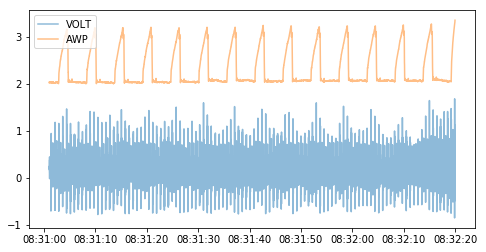

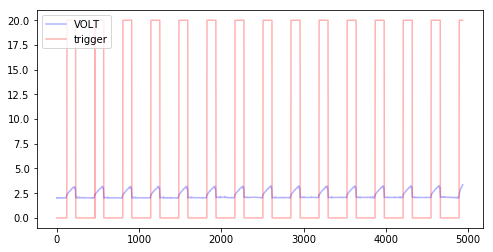

NameError: name 'breathing_start' is not defined

In [4]:

for i in range(0,len(df_dict["Time"])-1):
    if df_dict["State"].isnull()[i] == False:
        if df_dict["State"][i]=="TLV" or df_dict["State"][i]=="Lt OLV" or df_dict["State"][i]=="Rt OLV" or df_dict["State"][i]=="VCM":
            fname_with_time = str(get_state_time(i)[0])+str(get_state_time(i)[1])+str(get_state_time(i)[2])+'_'+str(get_state_time(i)[3])+'_'+str(get_state_time(i)[4])+'_'+str(get_state_time(i)[5])+'to'+str(get_state_time(i)[6])+str(get_state_time(i)[7])+str(get_state_time(i)[8])+'_'+str(get_state_time(i)[9])+'_'+str(get_state_time(i)[10])+'_'+str(get_state_time(i)[11])+'_'+get_state_time(i)[12]
            print("*"*70)
            print('i =',i,'[fname_with_time]',fname_with_time)
            
            column_name=[]
            total_df=[]

            for j in range(0,len(device0_signal)+len(device1_signal)+len(device2_signal)):
                temp=[]
                if j<len(device0_signal):
#                     print('j =',j,'from', device0_name)
                    temp = vr_data.read_wave_datetime_interval(device0_name,device0_signal[j],datetime.datetime(get_state_time(j)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device0_signal[j])
                    column_name.append(device0_signal[j])

                elif j<len(device0_signal)+len(device1_signal):
#                     print('j =',j,'from', device1_name)
                    temp = vr_data.read_number_datetime_interval(device1_name,device1_signal[j-len(device0_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device1_signal[j-len(device0_signal)])
                    column_name.append(device1_signal[j-len(device0_signal)])

                else:
#                     print('j =',j,'from', device2_name)
                    temp = vr_data.read_wave_datetime_interval(device2_name,device2_signal[j-len(device0_signal)-len(device1_signal)],datetime.datetime(get_state_time(i)[0],get_state_time(i)[1],get_state_time(i)[2],get_state_time(i)[3],get_state_time(i)[4],get_state_time(i)[5]),datetime.datetime(get_state_time(i)[6],get_state_time(i)[7],get_state_time(i)[8],get_state_time(i)[9],get_state_time(i)[10],get_state_time(i)[11]))
                    time_df = pd.DataFrame(temp[0])
                    signal_df = pd.DataFrame(temp[1])
                    total_df = pd.concat([total_df,time_df, signal_df],ignore_index=False, axis=1)
                    column_name.append("Time_"+device2_signal[j-len(device0_signal)-len(device1_signal)])
                    column_name.append(device2_signal[j-len(device0_signal)-len(device1_signal)])

            total_df.columns = column_name
#             print(total_df.head(3))
            print('*'*70)
            make_output_dirs()
            extract_original_wav()
            HPSS()
            draw_spectrum()
            draw_MFCC()

print("Processing finished!!!")

In [ ]:
print(total_df['AWP'].mean)
print(total_df['AWP'].max)

In [ ]:
total_df

In [ ]:
total_df_normal = (total_df - total_df.mean()) / (total_df.max() - total_df.min())

In [ ]:
.mean()

In [ ]:
total_df['AWP'].mean()